# Deploying a trained model in Clipper

You need docker first: https://docs.docker.com/docker-for-mac/install/
        

## The trained model

This is just an example, in practice you would do this somewhere else and save the model.
Taken from here: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html


Confusion matrix, without normalization
[[13  0  0]
 [ 0 15  1]
 [ 0  0  9]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.   0.94 0.06]
 [0.   0.   1.  ]]


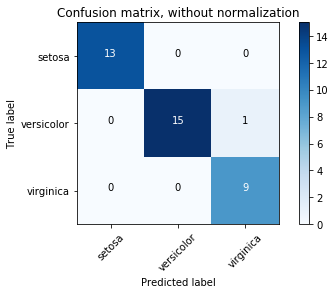

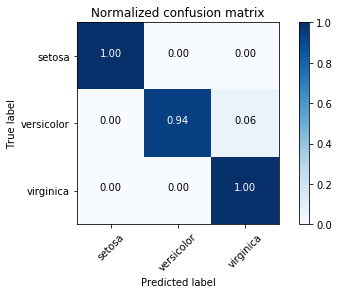

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt 
import itertools
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel='linear', C=0.1)
y_pred = classifier.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Generate some typical examples from each class to test the deployment

In [7]:
class_names[classifier.predict([[4.0, 2.0,1.0, 0.1]])][0]

'setosa'

In [8]:
class_names[classifier.predict([[7.9, 4.4,6.9, 2.5]])][0]

'virginica'

In [9]:
class_names[classifier.predict([[5.84, 3.05,3.76, 1.2]])][0]

'versicolor'

## Deploying a model with Clipper 
http://clipper.ai/

In [2]:
from clipper_admin import ClipperConnection, DockerContainerManager


In [13]:
clipper_conn = ClipperConnection(DockerContainerManager())

In [14]:
# Start Clipper. Running this command for the first time will
# download several Docker containers, so it may take some time.
try:
    clipper_conn.start_clipper()
except:
    print("Clipper already running")
    clipper_conn.connect()
    

18-09-29:08:14:35 INFO     [docker_container_manager.py:96] Starting managed Redis instance in Docker
18-09-29:08:14:37 INFO     [clipper_admin.py:109] Clipper still initializing.
18-09-29:08:14:38 INFO     [clipper_admin.py:111] Clipper is running


In [15]:

# Register an application called "hello_world". This will create
# a prediction REST endpoint at http://localhost:1337/hello_world/predict
clipper_conn.register_application(name="hello-world", 
                                  input_type="doubles", 
                                  default_output="-1.0", 
                                  slo_micros=100000)

clipper_conn.register_application(name="iris", 
                                  input_type="doubles", 
                                  default_output="-1.0", 
                                  slo_micros=100000)

# Inspect Clipper to see the registered apps
clipper_conn.get_all_apps()


18-09-29:08:16:30 INFO     [clipper_admin.py:186] Application hello-world was successfully registered
18-09-29:08:16:30 INFO     [clipper_admin.py:186] Application iris was successfully registered


[u'hello-world', u'iris']

In [16]:

# Define a simple model that just returns the sum of each feature vector.
# Note that the prediction function takes a list of feature vectors as
# input and returns a list of strings.
def feature_sum(xs):
    return [str(sum(x)) for x in xs]


In [17]:

# Define a function that serves our trained iris model

# Note that the prediction function takes a list of feature vectors as
# input and returns a list of strings.
def iris_predict(xs):
    print(xs)
    ret = class_names[classifier.predict(xs)][0]
    return [ret]

In [18]:

# Import the python deployer package
from clipper_admin.deployers import python as python_deployer


In [19]:

# Deploy the "feature_sum" function as a model. Notice that the application and model
# must have the same input type.
python_deployer.deploy_python_closure(clipper_conn, 
                                      name="sum-model", 
                                      version=1, 
                                      input_type="doubles", 
                                      func=feature_sum)


# Tell Clipper to route requests for the "hello-world" application to the "sum-model"
clipper_conn.link_model_to_app(app_name="hello-world", 
                               model_name="sum-model")

# Your hello-world application is now ready to serve predictions

18-09-29:08:18:19 INFO     [deployer_utils.py:42] Saving function to /tmp/clipper/tmpZccw2g
18-09-29:08:18:19 INFO     [deployer_utils.py:63] Warning: Anaconda environment was either not found or exporting the environment failed. Your function will still be serialized and deployed, but may fail due to missing dependencies. In this case, please re-run inside an Anaconda environment. See http://clipper.ai/documentation/python_model_deployment/ for more information.
18-09-29:08:18:19 INFO     [deployer_utils.py:72] Supplied local modules
18-09-29:08:18:19 INFO     [deployer_utils.py:78] Serialized and supplied predict function
18-09-29:08:18:19 INFO     [python.py:166] Python closure saved
18-09-29:08:18:19 INFO     [clipper_admin.py:381] Building model Docker image with model data from /tmp/clipper/tmpZccw2g
18-09-29:08:18:19 INFO     [clipper_admin.py:385] Pushing model Docker image to sum-model:1
18-09-29:08:18:20 INFO     [docker_container_manager.py:205] Found 0 replicas for sum-mode

In [20]:
# Deploy the "iris_predict" function as a model. Notice that the application and model
# must have the same input type.
python_deployer.deploy_python_closure(clipper_conn, 
                                      name="iris-model", 
                                      version=3, 
                                      input_type="doubles", 
                                      func=iris_predict,
                                      pkgs_to_install=['scipy', 'scikit-learn'])


# Tell Clipper to route requests for the "iris" application to the "iris-model"
clipper_conn.link_model_to_app(app_name="iris", model_name="iris-model")

# Your iris application is now ready to serve predictions

18-09-29:08:19:13 INFO     [deployer_utils.py:42] Saving function to /tmp/clipper/tmpDKdOwB
18-09-29:08:19:13 INFO     [deployer_utils.py:63] Warning: Anaconda environment was either not found or exporting the environment failed. Your function will still be serialized and deployed, but may fail due to missing dependencies. In this case, please re-run inside an Anaconda environment. See http://clipper.ai/documentation/python_model_deployment/ for more information.
18-09-29:08:19:20 INFO     [deployer_utils.py:72] Supplied local modules
18-09-29:08:19:20 INFO     [deployer_utils.py:78] Serialized and supplied predict function
18-09-29:08:19:20 INFO     [python.py:166] Python closure saved
18-09-29:08:19:20 INFO     [clipper_admin.py:381] Building model Docker image with model data from /tmp/clipper/tmpDKdOwB
18-09-29:08:19:23 INFO     [clipper_admin.py:385] Pushing model Docker image to iris-model:3
18-09-29:08:19:24 INFO     [docker_container_manager.py:205] Found 0 replicas for iris-mo

## Querying the model

In [21]:
q1 = [4.3, 2.0,1.0, 0.1]
q2 = [5.84, 3.05,3.76, 1.2]
q3 = [7.9, 4.4, 6.9, 2.5]

In [22]:
import requests, json, numpy as np
headers = {"Content-type": "application/json"}

In [26]:
requests.post("http://localhost:1337/hello-world/predict", 
              headers=headers, 
              data=json.dumps({"input": q1})).json()

{u'default': True,
 u'default_explanation': u'No connected models found for query',
 u'output': -1.0,
 u'query_id': 6}

In [23]:
requests.post("http://localhost:1337/iris/predict", 
              headers=headers, 
              data=json.dumps({"input": q2})).json()

{u'default': False, u'output': u'versicolor', u'query_id': 0}

In [24]:
requests.post("http://localhost:1337/iris/predict", 
              headers=headers, 
              data=json.dumps({"input": q3})).json()

{u'default': False, u'output': u'virginica', u'query_id': 1}

In [25]:
# you would change the hostname here if you were on a server or AWS :)
requests.post("http://127.0.0.1:1337/iris/predict", 
              headers=headers, 
              data=json.dumps({"input": q3})).json()

{u'default': False, u'output': u'virginica', u'query_id': 2}

In [ ]:
requests.post("http://localhost:1337/iris/predict", 
              headers=headers, 
              data=json.dumps({"input": q2})).json()

You can query remotely by replacing the localhost IP address with your address on the network, e.g.
curl -X POST --header "Content-Type:application/json" -d '{"input": [4.3, 2.0,1.0, 0.1]}' 172.16.34.147:1337/iris/predict

## Shutting it all down

In [26]:
# If you have still have the Python REPL from earlier,
# skip directly to clipper_conn.stop_all()
from clipper_admin import ClipperConnection, DockerContainerManager
clipper_conn = ClipperConnection(DockerContainerManager())
clipper_conn.connect()

18-06-01:16:58:41 INFO     [clipper_admin.py:123] Successfully connected to Clipper cluster at localhost:1337


In [26]:
# Stop all Clipper docker containers
clipper_conn.stop_all()

18-09-29:08:22:12 INFO     [clipper_admin.py:1155] Stopped all Clipper cluster and all model containers


## Checking on the deployment

In [22]:
clipper_conn.get_clipper_logs()

['/Users/damciv01/Documents/PycharmProjects/datSciAfrica18/clipper_logs/image_sha256:7225a284af:container_7338da03ec.log',
 '/Users/damciv01/Documents/PycharmProjects/datSciAfrica18/clipper_logs/image_sha256:7ce07e68fe:container_c9fd1eb3ab.log',
 '/Users/damciv01/Documents/PycharmProjects/datSciAfrica18/clipper_logs/image_sha256:6b8f015eee:container_0de2e9d4d5.log',
 '/Users/damciv01/Documents/PycharmProjects/datSciAfrica18/clipper_logs/image_sha256:db23f46600:container_4fd3dd7915.log']

In [23]:
clipper_conn.cm.get_num_replicas(name="iris-model", version='3')

1

In [24]:
clipper_conn.cm.get_num_replicas(name="sum-model", version='1')

0